###Churn/ Customer Retention Modeling

##

In [305]:
#Load in libraries
library(dplyr)
library(binr)
library(OneR)
library(ggplot2)
library(GGally)
library(car)
library(reshape)
library(devtools)
library(openxlsx)
library(zip)
library(RColorBrewer)
library(caret)
library(e1071)
library(pROC)
library(plotly)
library(crosstalk)
# R.Version()

In [344]:
# load in the data. The data was pre-cleaned with a mixture of python and R after querying the source data base.
model_data <- read.csv('df_combined_012619.csv')

In [336]:
model_data$pid <- as.integer(model_data$pid)

In [337]:
str(model_data)

'data.frame':	9925 obs. of  61 variables:
 $ X                              : int  1 2 3 4 5 6 7 8 9 10 ...
 $ pid                            : int  2539 9236 1027 1309 4303 5176 2753 5283 5308 3337 ...
 $ birth.year                     : Factor w/ 7430 levels "1918-01-15","1918-01-24",..: 2828 1379 1151 3493 4423 7082 2433 2889 103 1699 ...
 $ first.payment                  : Factor w/ 288 levels "2018-01-17","2018-01-24",..: 231 112 NA 253 133 227 122 153 152 68 ...
 $ last.payment                   : Factor w/ 3015 levels "2018-01-17 00:00:00",..: 1803 759 243 2026 2136 1457 2587 1796 999 2420 ...
 $ transaction.count              : int  4 8 NA 3 8 4 8 6 7 11 ...
 $ total.spend                    : num  596 392 NA 447 792 ...
 $ processor                      : Factor w/ 2 levels "Square","Stripe": 2 2 2 2 2 2 2 2 2 2 ...
 $ customer.status                : Factor w/ 2 levels "Existing","New": 2 1 2 1 1 2 2 1 2 1 ...
 $ clinic.id                      : int  24 9 17 19 33 40 25 40 40

In [382]:
model_data$avg_visits <- apply(select(model_data,starts_with("num_visits")),
                               1,function(x) mean(x,na.rm = TRUE))

model_data$first_month_weightlost <- apply(select(model_data,starts_with("weightchange")),
                                            1,function(x) which(x < 0)[1]) - model_data$first_month_visited + 1

model_data$first_month_weightlost_10 <- apply(select(model_data,starts_with("weightchange")),
                                               1,function(x) which(x <= -10)[1]) - model_data$first_month_visited + 1


model_data$first_month_weightgain <- apply(select(model_data,starts_with("weightchange")),
                                            1,function(x) which(x > 1)[1]) - model_data$first_month_visited + 1


model_data$first_month_weightgain_10 <- apply(select(model_data,starts_with("weightchange")),
                                               1,function(x) which(x >= 10)[1]) - model_data$first_month_visited + 1

model_data$avg_weight_change <- apply(select(model_data,starts_with("weightchange")),
                                       1,function(x) mean(x,na.rm = TRUE))

model_data$stdev_visits <- apply(select(model_data,starts_with("num_visits")),
                                  1,function(x) sd(x,na.rm = TRUE))

model_data$stdev_weight_change <- apply(select(model_data,starts_with("weightchange")),
                                         1,function(x) sd(x,na.rm = TRUE))

In [345]:
model_data_discrete$pid <- model_data$pid

In [340]:
length(unique(model_data_discrete$pid))

[1] 9562

In [422]:
dim(model_data_discrete)

[1] 10189    27

In [412]:
#read in new data with gender added
gender_data <- read.csv('datawithgenderbothpids.csv', stringsAsFactors = FALSE)
head(gender_data)

X.1,X,pid,birth.year,first.payment,last.payment,transaction.count,total.spend,processor,customer.status,...,first_month_0_visits,consec_0_visits,consec_0_visits_v2,first_month_visited,firstpay_index,churn_v2,visitsuntil_weightlost,visitsuntil_weightlost_factor,pid2,gender
1,1,24Oes9064,1962-04-26,2018-10-25,2018-12-25 18:13:00,4,596,Stripe,New,...,1,8,0,9,9,NoChurn,1,1,24OesM4471,F
2,2,9Coy9025,1954-06-14,2018-06-01,2018-12-01 18:39:00,8,392,Stripe,Existing,...,1,6,1,2,5,Churn,-1,Didnt Lose Weight,9CoyA5182,F
3,3,17Abo9059,1952-12-07,NA,2018-06-18 16:41:00,NA,NA,Stripe,New,...,1,5,1,4,4,Churn,1,1,17AboS9791,F
4,4,19Bar1443,1965-06-07,2018-11-28,2018-12-28 17:03:00,3,447,Stripe,Existing,...,1,9,0,10,10,NoChurn,2,2 to 3,19BarM4357,F
5,5,33Fai3547,1969-12-09,2018-06-29,2018-12-29 20:04:00,8,792,Stripe,Existing,...,1,5,1,6,5,Churn,1,1,33FaiK4793,F
6,6,40Gra9064,1993-10-31,2018-10-19,2018-12-19 19:28:00,4,247,Stripe,New,...,1,8,0,9,9,NoChurn,2,2 to 3,40GraK4623,F


In [415]:
#joining in gender data and corrected primary key
model_data_discrete <- left_join(model_data_discrete, gender_data[,c('pid','pid2','gender','visitsuntil_weightlost_factor')], by = 'pid')

Warning message:
"Column `pid` joining factor and character vector, coercing into character vector"

In [453]:
# str(model_data_discrete$gender)
# model_data_discrete$gender <- tolower(model_data_discrete$gender)
# model_data_discrete$gender <- ifelse(model_data_discrete$gender == 'm','Male','Female')
model_data_discrete$gender <- as.factor(model_data_discrete$gender)


In [458]:
model_data_discrete <- model_data_discrete[!is.na(model_data_discrete$gender),]

In [423]:
#Some duplicates remained so need to remove them
model_data_discrete <- model_data_discrete[!duplicated(model_data_discrete$pid),]
str(model_data_discrete)

'data.frame':	9562 obs. of  27 variables:
 $ pid                          : chr  "24Oes9064" "9Coy9025" "17Abo9059" "19Bar1443" ...
 $ avg_weight_change            : num  -1.882 0 -0.1 -0.927 -0.182 ...
 $ avg_visits                   : num  3.364 0.364 1.091 1.727 0.727 ...
 $ stdev_weight_change          : num  3.527 0 0.173 3.075 0.603 ...
 $ stdev_visits                 : num  6.816 0.674 1.921 5.405 2.412 ...
 $ consec_0_visits_v2           : int  0 1 1 0 1 0 0 0 0 0 ...
 $ first_month_weightlost       : num  0 0 0 1 0 1 0 0 0 0 ...
 $ first_month_weightgain       : num  0 0 0 0 0 0 2 0 0 0 ...
 $ membership                   : Factor w/ 3 levels "BWM","WPM","WUM": 3 1 1 3 2 1 1 1 2 2 ...
 $ processor                    : Factor w/ 2 levels "Square","Stripe": 2 2 2 2 2 2 2 2 2 2 ...
 $ total.spend                  : num  596 392 0 447 792 ...
 $ birth.year                   : Factor w/ 7430 levels "1918-01-15","1918-01-24",..: 2828 1379 1151 3493 4423 7082 2433 2889 103 1699 ...
 

In [224]:
#Create a generation variable
model_data_discrete$generation <- as.factor(ifelse(is.na(model_data_discrete$birthyear_factor), "Gen X",ifelse(
  model_data_discrete$birthyear_factor <= 1945, "Silent",ifelse(
  model_data_discrete$birthyear_factor <= 1964, "Baby Boomers",
  ifelse(    model_data_discrete$birthyear_factor <= 1979, "Gen X",
             ifelse(
               model_data_discrete$birthyear_factor <= 1985, "Xennials",
               ifelse(
                 model_data_discrete$birthyear_factor <= 1994, "Millennials",
                 ifelse(
                   model_data_discrete$birthyear_factor <= 2012, "iGen","Other"))))))))

In [283]:
#Discretize the data into bins
model_data_discrete <- model_data %>% select (pid,avg_weight_change,avg_visits, stdev_weight_change,stdev_visits,
                                              consec_0_visits_v2,first_month_weightlost, first_month_weightgain, membership, processor,
                                              total.spend,birth.year,churn_v2)

model_data_discrete$birthyear_factor <- as.integer(substr(model_data_discrete$birth.year,1,4))


#Filling in NAs with 0s
model_data_discrete[is.na(model_data_discrete)] <- -1 
model_data_discrete$churn_v2 <- as.factor(ifelse(model_data_discrete$churn_v2 == 0, 'No Churn', 'Churn'))



In [384]:
summary(model_data_discrete)

        pid       avg_weight_change    avg_visits       stdev_weight_change
 10Agu9063:   1   Min.   :-14.3545   Min.   : 0.09091   Min.   : 0.000     
 10Ala9061:   1   1st Qu.: -1.6000   1st Qu.: 1.45454   1st Qu.: 1.475     
 10Ale9027:   1   Median : -0.8364   Median : 2.90909   Median : 2.366     
 10Alv8979:   1   Mean   : -1.0364   Mean   : 3.62450   Mean   : 2.551     
 10Alv9061:   1   3rd Qu.: -0.2455   3rd Qu.: 5.00000   3rd Qu.: 3.347     
 10Ama9065:   1   Max.   : 25.3091   Max.   :31.00000   Max.   :86.087     
 (Other)  :9556                                                            
  stdev_visits    consec_0_visits_v2 first_month_weightlost
 Min.   : 0.000   Min.   :0.000      Min.   : 0.0000       
 1st Qu.: 1.969   1st Qu.:0.000      1st Qu.: 0.0000       
 Median : 3.668   Median :0.000      Median : 0.0000       
 Mean   : 3.920   Mean   :0.189      Mean   : 0.5818       
 3rd Qu.: 5.584   3rd Qu.:0.000      3rd Qu.: 1.0000       
 Max.   :17.677   Max.   :1.000 

In [143]:
#Merge the binned groups with the original data
test <- as.data.frame(apply(model_data_discrete[2:8],2,function(x) bin(x,nbins =5, method = "content")))
names(test) <- paste(names(test),"binned")
model_data_discrete <- cbind(model_data_discrete, test)
model_data_discrete$churn_v2 <- as.factor(model_data_discrete$churn_v2)
                            
levels(model_data_discrete$churn_v2) <- c("Churn","NoChurn")

In [416]:
str(model_data_discrete)

'data.frame':	10189 obs. of  27 variables:
 $ pid                          : chr  "24Oes9064" "9Coy9025" "17Abo9059" "19Bar1443" ...
 $ avg_weight_change            : num  -1.882 0 -0.1 -0.927 -0.182 ...
 $ avg_visits                   : num  3.364 0.364 1.091 1.727 0.727 ...
 $ stdev_weight_change          : num  3.527 0 0.173 3.075 0.603 ...
 $ stdev_visits                 : num  6.816 0.674 1.921 5.405 2.412 ...
 $ consec_0_visits_v2           : int  0 1 1 0 1 0 0 0 0 0 ...
 $ first_month_weightlost       : num  0 0 0 1 0 1 0 0 0 0 ...
 $ first_month_weightgain       : num  0 0 0 0 0 0 2 0 0 0 ...
 $ membership                   : Factor w/ 3 levels "BWM","WPM","WUM": 3 1 1 3 2 1 1 1 2 2 ...
 $ processor                    : Factor w/ 2 levels "Square","Stripe": 2 2 2 2 2 2 2 2 2 2 ...
 $ total.spend                  : num  596 392 0 447 792 ...
 $ birth.year                   : Factor w/ 7430 levels "1918-01-15","1918-01-24",..: 2828 1379 1151 3493 4423 7082 2433 2889 103 1699 ...


In [385]:
#Combine the binned data with the original data
test <- as.data.frame(apply(select(model_data_discrete,avg_weight_change,avg_visits,stdev_weight_change,
                                   stdev_visits,first_month_weightlost,first_month_weightgain,total.spend,
                                   ),2,function(x) bin(x,nbins =5, method = "content")))

names(test) <- paste(names(test),"binned")
model_data_discrete <- cbind(model_data_discrete, test)

In [386]:
#Change some of the levels since they are confusing
levels(model_data_discrete$`first_month_weightgain binned`) <- c("0","1 to 3","4 to 10")

levels(model_data_discrete$`first_month_weightlost binned`) <- c("0","1","2 to 10")
levels(model_data_discrete$`avg_weight_change binned`) <- c("0 to 25","-0.6 to -0.1","-1.12 to -.6","-1.85 to -1.12",
                                                            "-14.4 to -1.85")
levels(model_data_discrete$`avg_visits binned`) <- c("0 to 1.18","1.18 to 2.27","2.27 to 3.73","3.73 to 5.65",
                                                            "5.65 to 31")

In [391]:
xxx <- model_data_discrete
str(xxx)

'data.frame':	9562 obs. of  31 variables:
 $ pid                          : Factor w/ 9562 levels "10Agu9063","10Ala9061",..: 2539 9236 1027 1309 4303 5176 2753 5283 5308 3337 ...
 $ avg_weight_change            : num  -1.882 0 -0.1 -0.927 -0.182 ...
 $ avg_visits                   : num  3.364 0.364 1.091 1.727 0.727 ...
 $ stdev_weight_change          : num  3.527 0 0.173 3.075 0.603 ...
 $ stdev_visits                 : num  6.816 0.674 1.921 5.405 2.412 ...
 $ consec_0_visits_v2           : int  0 1 1 0 1 0 0 0 0 0 ...
 $ first_month_weightlost       : num  0 0 0 1 0 1 0 0 0 0 ...
 $ first_month_weightgain       : num  0 0 0 0 0 0 2 0 0 0 ...
 $ membership                   : Factor w/ 3 levels "BWM","WPM","WUM": 3 1 1 3 2 1 1 1 2 2 ...
 $ processor                    : Factor w/ 2 levels "Square","Stripe": 2 2 2 2 2 2 2 2 2 2 ...
 $ total.spend                  : num  596 392 0 447 792 ...
 $ birth.year                   : Factor w/ 7430 levels "1918-01-15","1918-01-24",..: 2828 1

In [394]:
str(model_data_discrete)

'data.frame':	9562 obs. of  24 variables:
 $ pid                          : Factor w/ 9562 levels "10Agu9063","10Ala9061",..: 2539 9236 1027 1309 4303 5176 2753 5283 5308 3337 ...
 $ avg_weight_change            : num  -1.882 0 -0.1 -0.927 -0.182 ...
 $ avg_visits                   : num  3.364 0.364 1.091 1.727 0.727 ...
 $ stdev_weight_change          : num  3.527 0 0.173 3.075 0.603 ...
 $ stdev_visits                 : num  6.816 0.674 1.921 5.405 2.412 ...
 $ consec_0_visits_v2           : int  0 1 1 0 1 0 0 0 0 0 ...
 $ first_month_weightlost       : num  0 0 0 1 0 1 0 0 0 0 ...
 $ first_month_weightgain       : num  0 0 0 0 0 0 2 0 0 0 ...
 $ membership                   : Factor w/ 3 levels "BWM","WPM","WUM": 3 1 1 3 2 1 1 1 2 2 ...
 $ processor                    : Factor w/ 2 levels "Square","Stripe": 2 2 2 2 2 2 2 2 2 2 ...
 $ total.spend                  : num  596 392 0 447 792 ...
 $ birth.year                   : Factor w/ 7430 levels "1918-01-15","1918-01-24",..: 2828 1

In [ ]:
## Plotting 

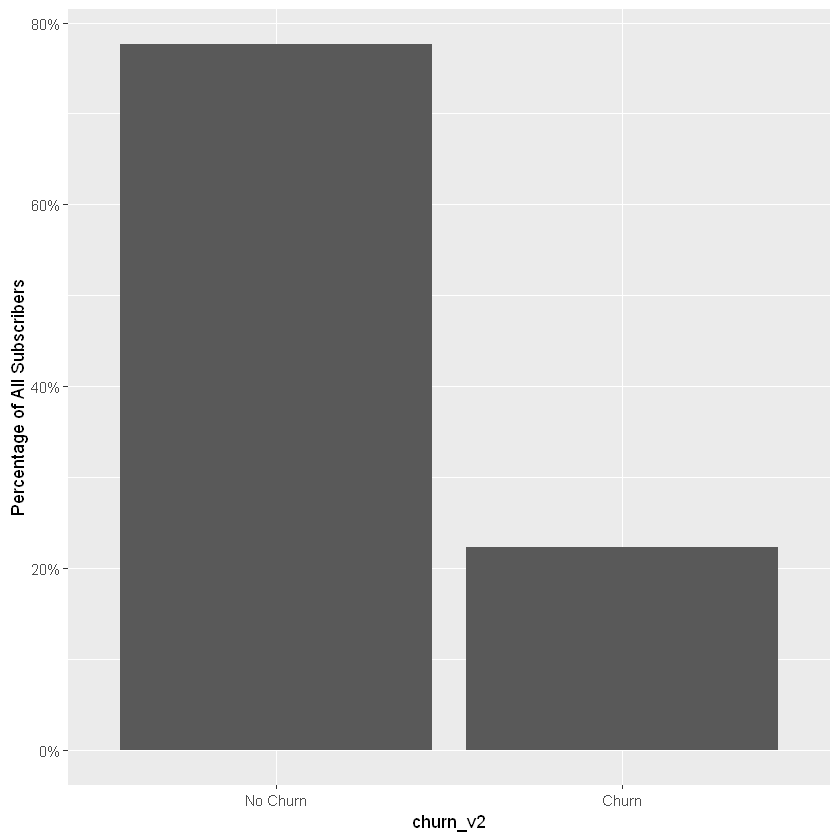

In [210]:
# Basic plot showing churn vs non-churn in our data
g <- ggplot(model_data_discrete,aes(churn_v2))
g + geom_bar(aes(y = (..count..)/sum(..count..)))+
scale_y_continuous(labels = scales::percent)+
ylab("Percentage of All Subscribers")



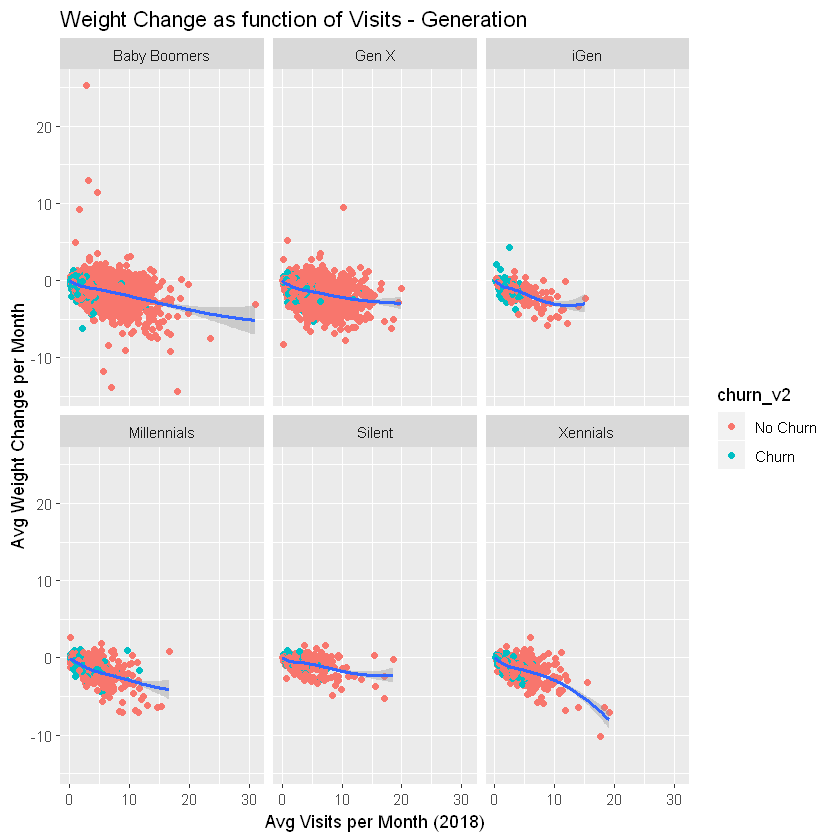

In [428]:
#Let's look at average weight change per month as a function of average visits per month: we expect a high correlation
g2 <- ggplot(model_data_discrete, aes(x = avg_visits, y = avg_weight_change))+
  geom_point(aes(colour = churn_v2))+
  geom_smooth(method = 'loess', formula = y ~ x)+
  facet_wrap(~generation)+
    labs(x = 'Avg Visits per Month (2018)',y = 'Avg Weight Change per Month',title = 'Weight Change as function of Visits - Generation')
  

g2
# ggsave('WtChange_Visits_Generation.png', plot = g2)

Warning message:
"Removed 7 rows containing non-finite values (stat_boxplot)."

Saving 6.67 x 6.67 in image
Warning message:
"Removed 7 rows containing non-finite values (stat_boxplot)."

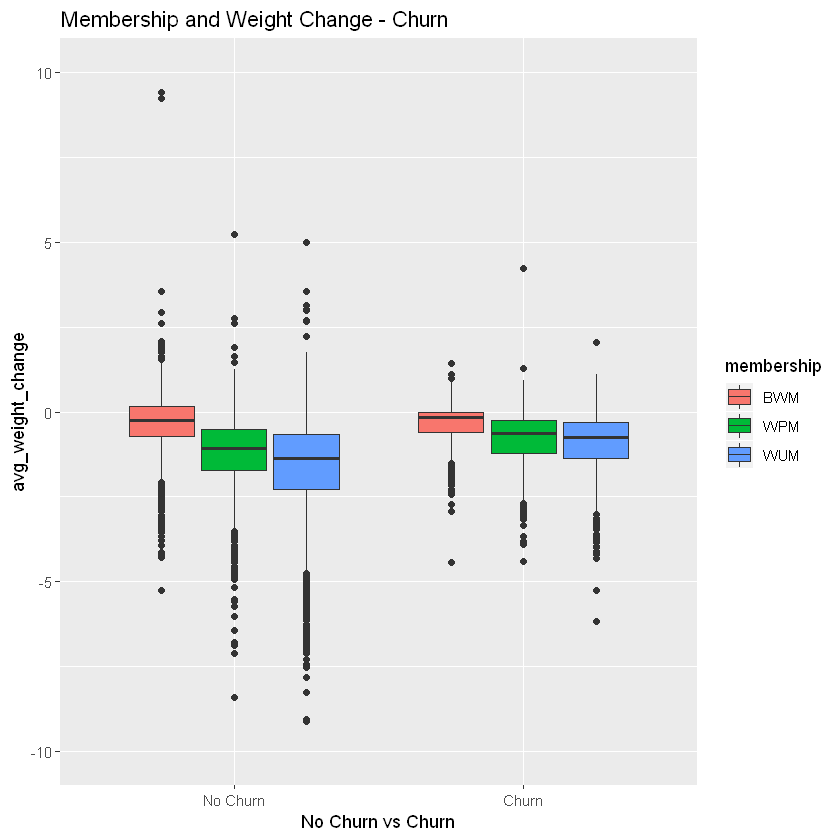

In [404]:
#Now lets look at membership type avg weight change and churn
boxplot_1 <- qplot(x = as.factor(model_data_discrete$churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
                 fill = membership, main = "Membership and Weight Change - Churn",xlab = 'No Churn vs Churn', ylim = c(-10,10))
boxplot_1

ggsave('Membership and weight change.png',boxplot_1)

Warning message:
"Removed 7 rows containing non-finite values (stat_boxplot)."

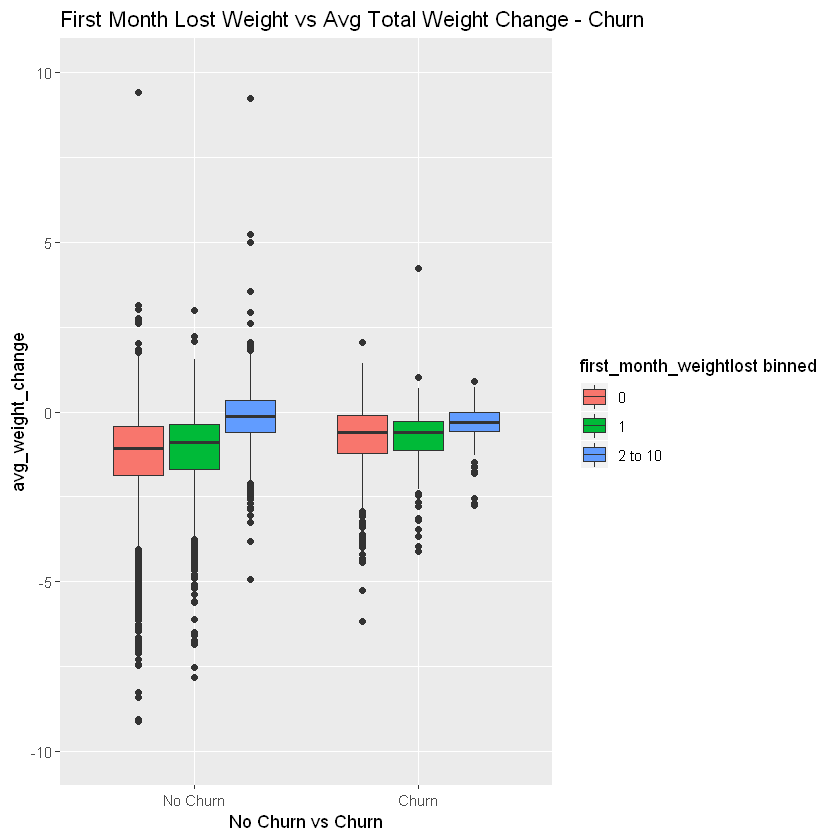

In [407]:
#Now lets look at first month sub lost weight vs avg weight change and churn

boxplot_2 <- qplot(x = as.factor(churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
                   fill = `first_month_weightlost binned`, main = "First Month Lost Weight vs Avg Total Weight Change - Churn",
                  xlab = 'No Churn vs Churn', ylim = c(-10,10))

boxplot_2


Warning message:
"Removed 7 rows containing non-finite values (stat_boxplot)."

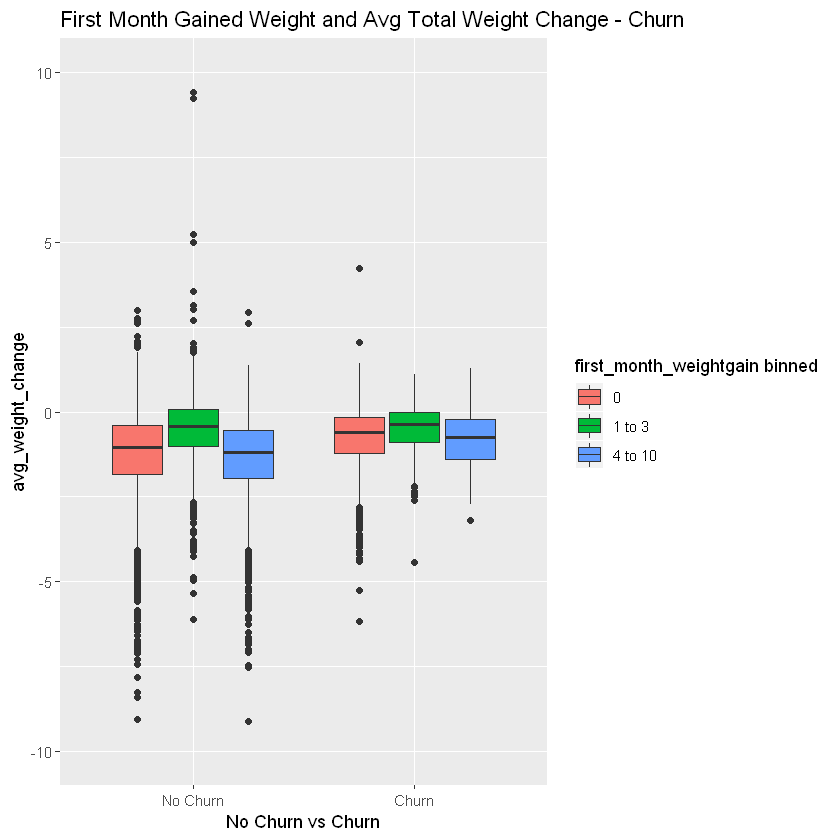

In [410]:
#Now lets look at first month sub gained weight vs avg weight change and churn

boxplot_3 <- qplot(x = as.factor(churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
                   fill = `first_month_weightgain binned`, main = "First Month Gained Weight and Avg Total Weight Change - Churn",
                  xlab = 'No Churn vs Churn', ylim = c(-10,10))

boxplot_3

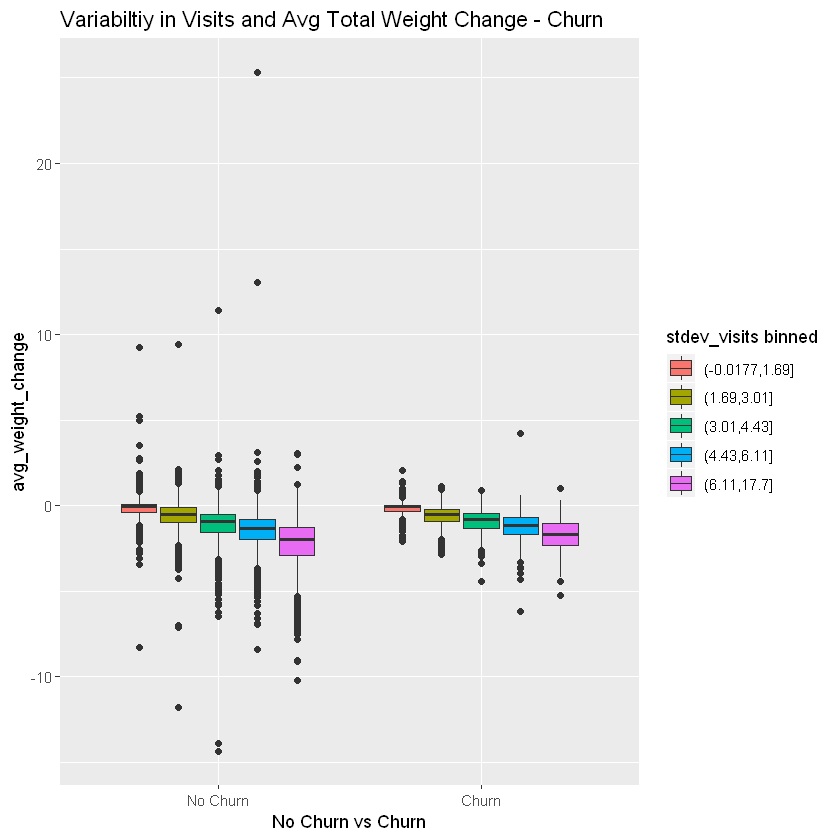

In [276]:
#Now lets look at variability in visits per month vs avg weight change and churn


boxplot_4 <- qplot(x = as.factor(churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
                   fill = `stdev_visits binned`, main = "Variabiltiy in Visits and Avg Total Weight Change - Churn",xlab = 'No Churn vs Churn')
boxplot_4

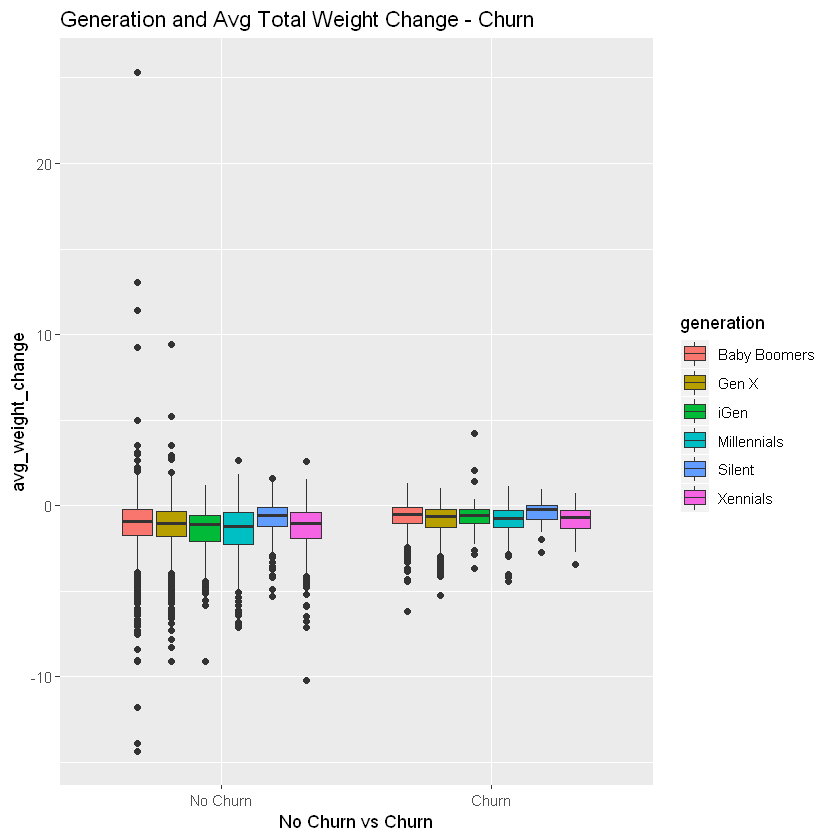

In [277]:
#Now lets look at generation vs avg weight change and churn

boxplot_5 <- qplot(x = as.factor(churn_v2), y = avg_weight_change, data = model_data_discrete,geom="boxplot", 
                   fill = generation, main = "Generation and Avg Total Weight Change - Churn", xlab = 'No Churn vs Churn')
boxplot_5

In [187]:
#Need to re-level churn variable since it was throwing off the visualizations
model_data_discrete$churn_v2 <- factor(model_data_discrete$churn_v2,levels(model_data_discrete$churn_v2)[c(2,1)])

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

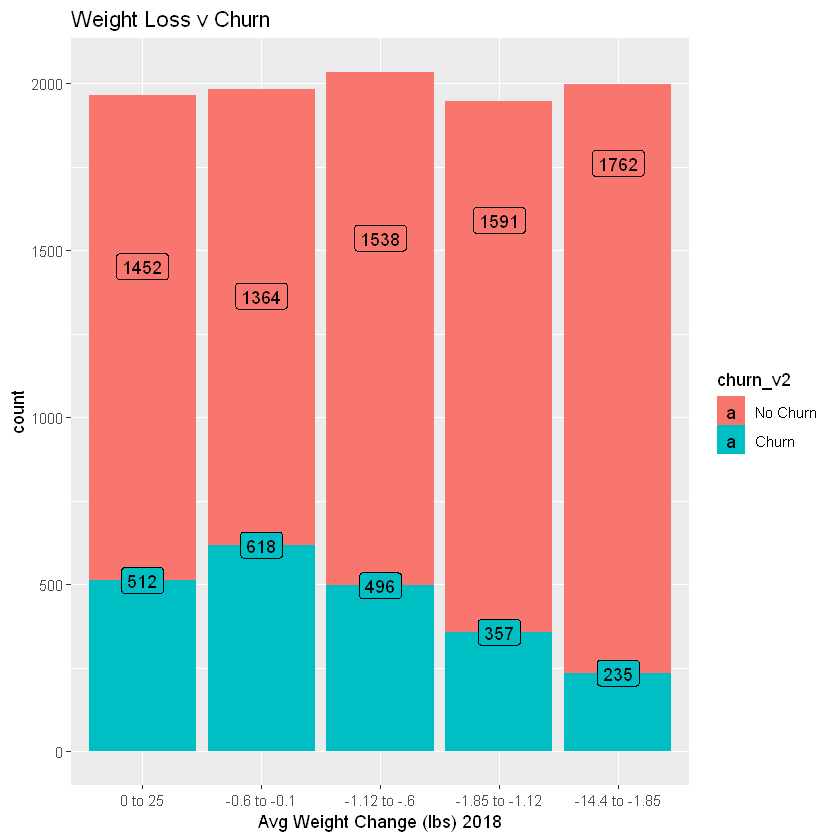

In [241]:
bar_avg_weight_change <- ggplot(data=model_data_discrete, aes(x=`avg_weight_change binned`, fill = churn_v2)) +
  geom_bar() +
  geom_label(stat='count', aes(label=..count..), position = 'dodge')+
  labs(x = 'Avg Weight Change (lbs) 2018',title = 'Weight Loss v Churn')

bar_avg_weight_change

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

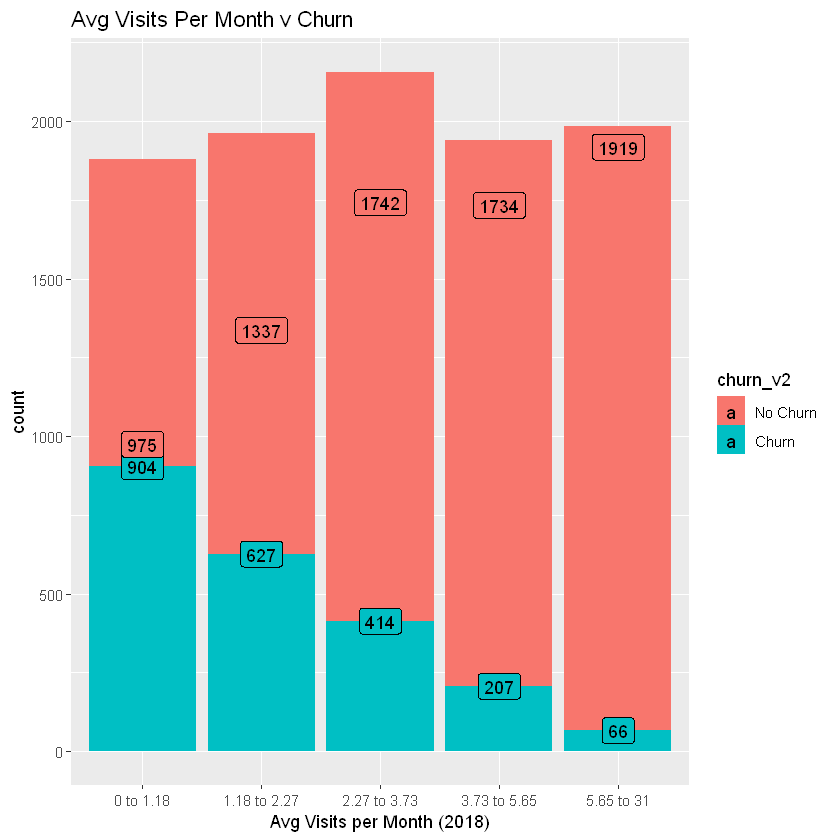

In [242]:
bar_avg_visits <- ggplot(data=model_data_discrete, aes(x=`avg_visits binned`, fill = churn_v2)) +
  geom_bar() +
  geom_label(stat='count', aes(label=..count..), position = 'dodge')+
  labs(x = 'Avg Visits per Month (2018)',title = 'Avg Visits Per Month v Churn')

bar_avg_visits

# bar_avg_visits

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

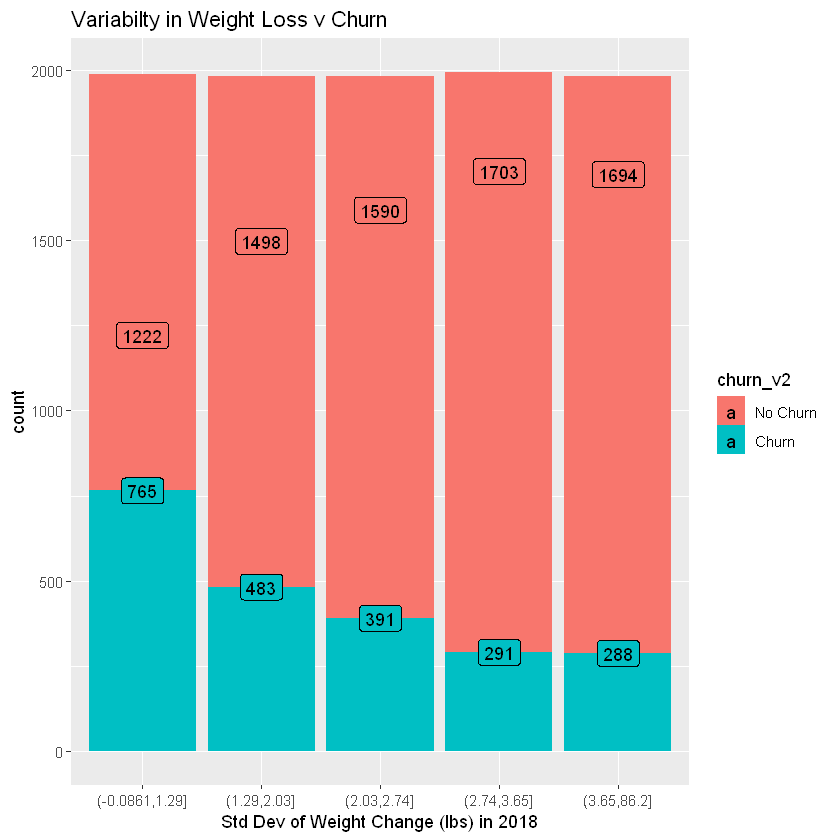

In [243]:
bar_std_weight_change <- ggplot(data=model_data_discrete, aes(x=`stdev_weight_change binned`, fill = churn_v2)) +
  geom_bar() +
  geom_label(stat='count', aes(label=..count..), position = 'dodge')+
  labs(x = 'Std Dev of Weight Change (lbs) in 2018',title = 'Variabilty in Weight Loss v Churn')

bar_std_weight_change

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

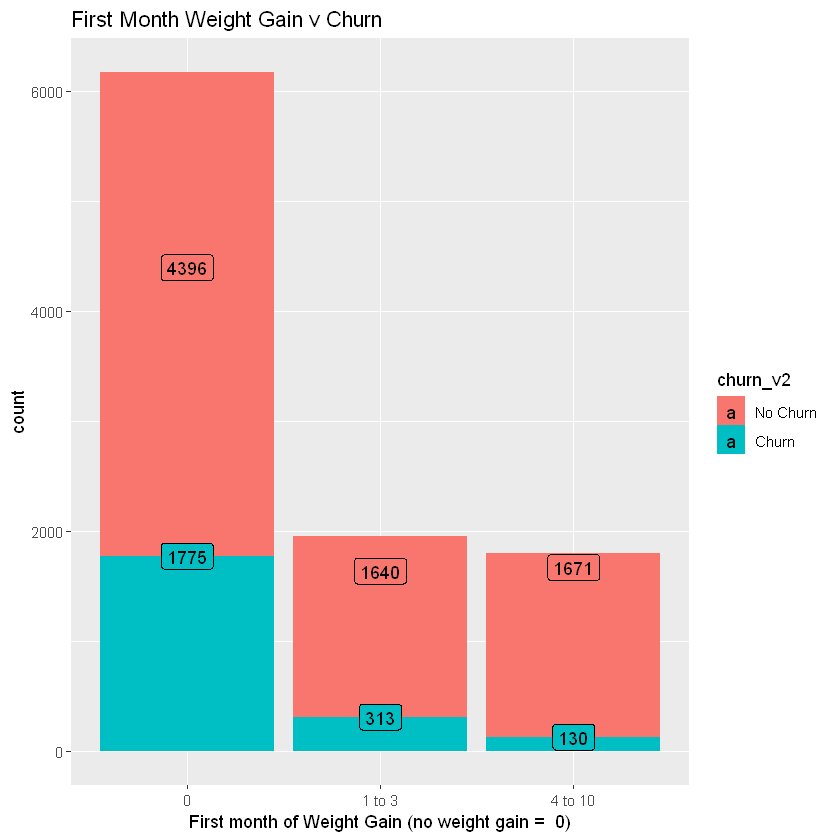

In [244]:
bar_first_month_gain <- ggplot(data=model_data_discrete, aes(x=`first_month_weightgain binned`, fill = churn_v2)) +
  geom_bar() +
  geom_label(stat='count', aes(label=..count..), position = 'dodge')+
  labs(title = 'First Month Weight Gain v Churn', x = "First month of Weight Gain (no weight gain =  0)")

bar_first_month_gain

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

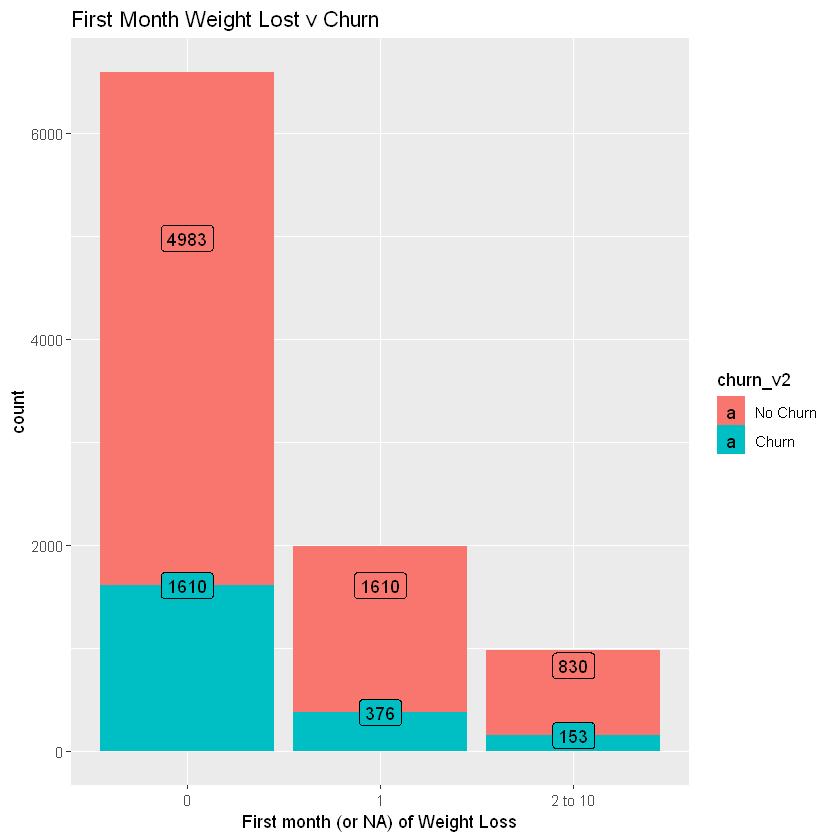

In [406]:
bar_first_month_lost <- ggplot(data=model_data_discrete, aes(x=`first_month_weightlost binned`, fill = churn_v2)) +
  geom_bar() +
  geom_label(stat='count', aes(label=..count..), position = 'dodge')+
  labs(title = 'First Month Weight Lost v Churn', x = "First month (or NA) of Weight Loss")

bar_first_month_lost

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"

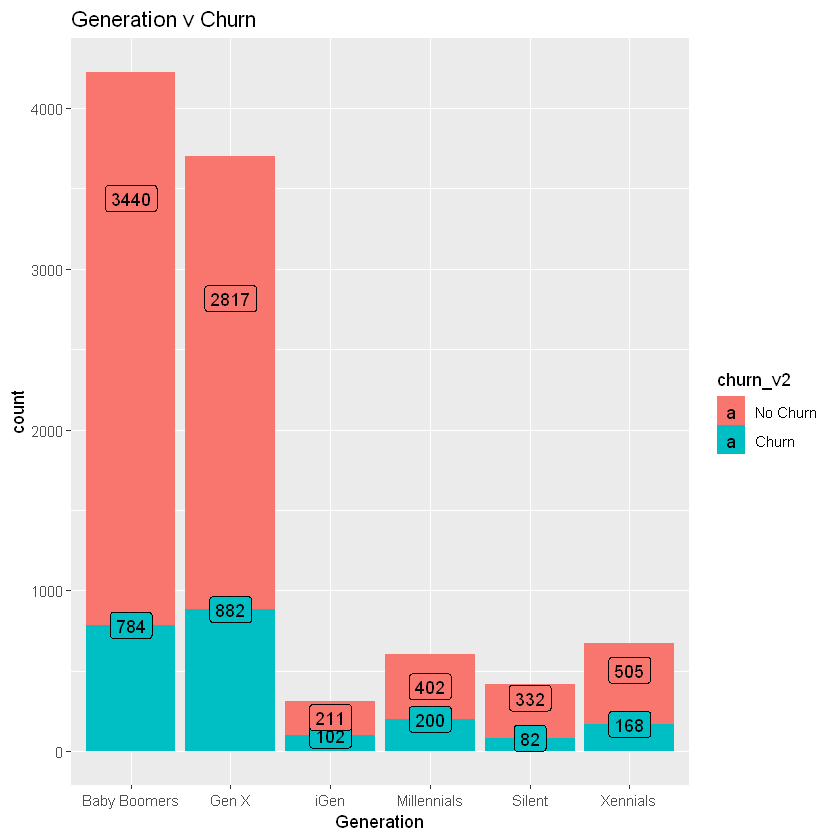

In [245]:
bar_gen <- ggplot(data=model_data_discrete, aes(x=generation, fill = churn_v2)) +
  geom_bar() +
  geom_label(stat='count', aes(label=..count..), position = 'dodge')+
  labs(x = 'Generation',title = 'Generation v Churn')

bar_gen

In [319]:
colnames(model_data_discrete)

[1] "pid"                           "avg_weight_change"            
 [3] "avg_visits"                    "stdev_weight_change"          
 [5] "stdev_visits"                  "consec_0_visits_v2"           
 [7] "first_month_weightlost"        "first_month_weightgain"       
 [9] "membership"                    "processor"                    
[11] "total.spend"                   "birth.year"                   
[13] "churn_v2"                      "birthyear_factor"             
[15] "generation"                    "avg_weight_change binned"     
[17] "avg_visits binned"             "stdev_weight_change binned"   
[19] "stdev_visits binned"           "first_month_weightlost binned"
[21] "first_month_weightgain binned" "total.spend binned"           
[23] "predicted_glm_NoChurn"         "predicted_glm_Churn"

In [379]:
# p <- plot_ly(
#   model_data_discrete, x = ~avg_visits, y = ~avg_weight_change,
#   color = ~predicted_glm_Churn, size = ~predicted_glm_Churn
# )
# p

In [327]:
colnames(model_data_discrete)

[1] "pid"                           "avg_weight_change"            
 [3] "avg_visits"                    "stdev_weight_change"          
 [5] "stdev_visits"                  "consec_0_visits_v2"           
 [7] "first_month_weightlost"        "first_month_weightgain"       
 [9] "membership"                    "processor"                    
[11] "total.spend"                   "birth.year"                   
[13] "churn_v2"                      "birthyear_factor"             
[15] "generation"                    "avg_weight_change binned"     
[17] "avg_visits binned"             "stdev_weight_change binned"   
[19] "stdev_visits binned"           "first_month_weightlost binned"
[21] "first_month_weightgain binned" "total.spend binned"           
[23] "predicted_glm_NoChurn"         "predicted_glm_Churn"

##Lets explore plotly in R 

In [380]:

# p_3d <- plot_ly(model_data_discrete, x = ~avg_visits, y = ~avg_weight_change, z = ~predicted_glm_Churn, color = ~churn_v2, colors = c('#BF382A', '#0C4B8E')) %>%
#   add_markers() %>%
#   layout(scene = list(xaxis = list(title = 'Avg Monthly Visits'),
#                      yaxis = list(title = 'Avg Monhtly Weight Change'),
#                      zaxis = list(title = 'Predicted Churn Probability')))
# p_3d


##Highly correlated predictors: make sure we dont include these in certain models to avoid multi-collinearity

Warning message in eval(expr, envir, enclos):
"restarting interrupted promise evaluation"Warning message in eval(expr, envir, enclos):
"internal error -3 in R_decompress1"

ERROR: Error in eval(expr, envir, enclos): lazy-load database 'C:/Users/markl/Anaconda3/Lib/R/library/RColorBrewer/R/RColorBrewer.rdb' is corrupt


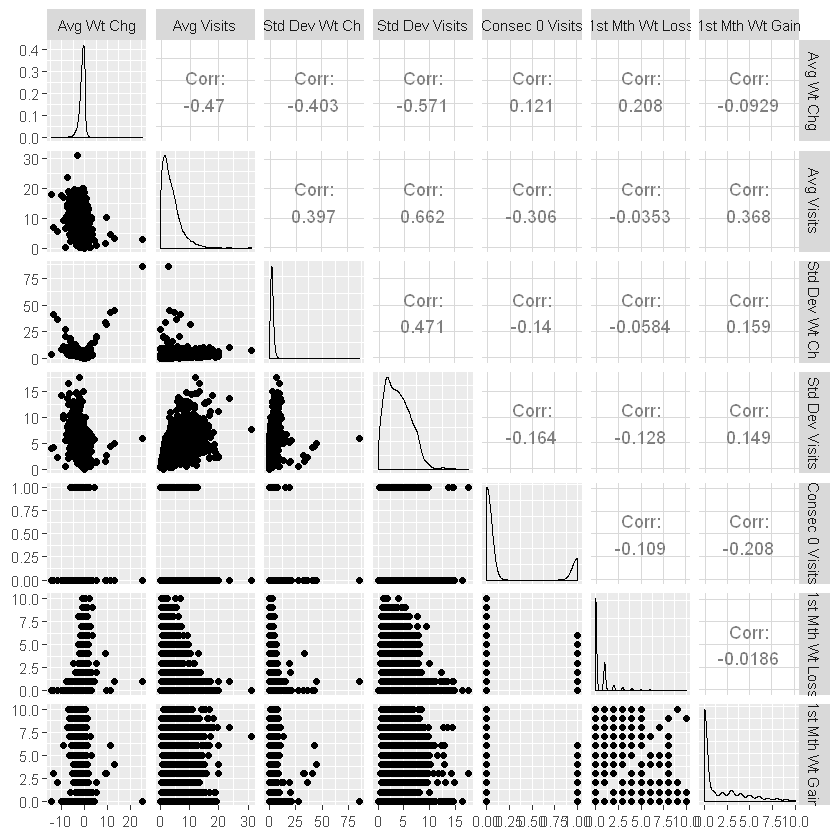

In [115]:
ggpairs(model_data_discrete[,2:8], columnLabels = c("Avg Wt Chg","Avg Visits","Std Dev Wt Ch ","Std Dev Visits","Consec 0 Visits",
                                                   "1st Mth Wt Loss","1st Mth Wt Gain"))


my_colors <- brewer.pal(nlevels(as.factor(model_data_discrete$churn_v2)), "Set2")

In [ ]:
# Split the data into training and test sets; setting our seed to 123 for reproducible results

In [460]:
set.seed(123)
train_index <- caret::createDataPartition(model_data_discrete$churn_v2,p = 0.7, list = FALSE)
train_set <- model_data_discrete[train_index,]
test_set <- model_data_discrete[-train_index,]

In [ ]:
#Using Caret train function, we can pre-process using centering and scaling

In [430]:
colnames(train_set)

[1] "pid"                           "avg_weight_change"            
 [3] "avg_visits"                    "stdev_weight_change"          
 [5] "stdev_visits"                  "consec_0_visits_v2"           
 [7] "first_month_weightlost"        "first_month_weightgain"       
 [9] "membership"                    "processor"                    
[11] "total.spend"                   "birth.year"                   
[13] "churn_v2"                      "birthyear_factor"             
[15] "generation"                    "avg_weight_change binned"     
[17] "avg_visits binned"             "stdev_weight_change binned"   
[19] "stdev_visits binned"           "first_month_weightlost binned"
[21] "first_month_weightgain binned" "total.spend binned"           
[23] "predicted_glm_NoChurn"         "predicted_glm_Churn"          
[25] "pid2"                          "gender"                       
[27] "visitsuntil_weightlost_factor"

In [461]:
model_glm <- caret::train(churn_v2 ~ `avg_weight_change binned`+ `avg_visits binned` + gender + visitsuntil_weightlost_factor +
                              `first_month_weightgain binned` + membership + `total.spend binned` + generation,preProc = c("center","scale"),
             data = train_set, method = "glm", family = "binomial")
 
 

In [462]:
model_glm

Generalized Linear Model 

6686 samples
   8 predictor
   2 classes: 'No Churn', 'Churn' 

Pre-processing: centered (26), scaled (26) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 6686, 6686, 6686, 6686, 6686, 6686, ... 
Resampling results:

  Accuracy   Kappa    
  0.7927289  0.2701546


In [463]:
#Calling summary on our model to view the coefficients: the coefficients are in relation to the reference level:
#e.g. avg weight change binned reference level is 
summary(model_glm)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9588  -0.7109  -0.3985  -0.1643   3.0003  

Coefficients:
                                                 Estimate Std. Error z value
(Intercept)                                      -1.67441    0.04423 -37.858
`\\`avg_weight_change binned\\`-0.6 to -0.1`      0.08635    0.04819   1.792
`\\`avg_weight_change binned\\`-1.12 to -.6`      0.06738    0.05194   1.297
`\\`avg_weight_change binned\\`-1.85 to -1.12`    0.01602    0.05565   0.288
`\\`avg_weight_change binned\\`-14.4 to -1.85`   -0.02644    0.06356  -0.416
`\\`avg_visits binned\\`1.18 to 2.27`            -0.27676    0.03863  -7.164
`\\`avg_visits binned\\`2.27 to 3.73`            -0.54787    0.04612 -11.879
`\\`avg_visits binned\\`3.73 to 5.65`            -0.83180    0.05417 -15.355
`\\`avg_visits binned\\`5.65 to 31`              -1.36805    0.07972 -17.161
genderMale                                        0.01748    0.03289   0.532
`visitsuntil

In [464]:
 exp(coef(model_glm$finalModel))


(Intercept) 
                                       0.1874195 
    `\\`avg_weight_change binned\\`-0.6 to -0.1` 
                                       1.0901899 
    `\\`avg_weight_change binned\\`-1.12 to -.6` 
                                       1.0697013 
  `\\`avg_weight_change binned\\`-1.85 to -1.12` 
                                       1.0161496 
  `\\`avg_weight_change binned\\`-14.4 to -1.85` 
                                       0.9739040 
           `\\`avg_visits binned\\`1.18 to 2.27` 
                                       0.7582337 
           `\\`avg_visits binned\\`2.27 to 3.73` 
                                       0.5781787 
           `\\`avg_visits binned\\`3.73 to 5.65` 
                                       0.4352667 
             `\\`avg_visits binned\\`5.65 to 31` 
                                       0.2546038 
                                      genderMale 
                                       1.0176368 
           `visitsuntil_weightlost_factor2 to 3` 
                                       0.8535209 
           `visitsuntil_weightlost_factor4 to 5` 
                                       0.8934474 
               `visitsuntil_weightlost_factor5+` 
                                       0.9843134 
`visitsuntil_weightlost_factorDidnt Lose Weight` 
                                       0.9977321 
     `\\`first_month_weightgain binned\\`1 to 3` 
                                       0.8753597 
    `\\`first_month_weightgain binned\\`4 to 10` 
                                       0.7302046 
                                   membershipWPM 
                                       1.0293239 
                                   membershipWUM 
                                       0.8548281 
   `\\`total.spend binned\\`(1.19e+03,4.52e+03]` 
                                       1.3813497 
             `\\`total.spend binned\\`(319,594]` 
                                       0.8040481 
             `\\`total.spend binned\\`(594,894]` 
                                       0.9656796 
        `\\`total.spend binned\\`(894,1.19e+03]` 
                                       1.3758188 
                               `generationGen X` 
                                       1.1015893 
                                  generationiGen 
                                       1.0909932 
                           generationMillennials 
                                       1.1918856 
                                generationSilent 
                                       0.9883649 
                              generationXennials 
                                       1.0228953

In [465]:
predictions_glm_1 <- predict(model_glm,test_set, type = "prob")
# colnames(predictions_glm_1) <- c('NoChurn','Churn')

In [230]:
model_glm_2 <- caret::train(churn_v2 ~ `avg_weight_change binned`+ `avg_visits binned` + generation
                               , data = train_set, method = "glm", family = "binomial")

In [231]:
model_glm_2

Generalized Linear Model 

6948 samples
   3 predictor
   2 classes: 'No Churn', 'Churn' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 6948, 6948, 6948, 6948, 6948, 6948, ... 
Resampling results:

  Accuracy   Kappa    
  0.7734036  0.1143439


In [290]:
exp(coef(model_glm_4$finalModel))

(Intercept) 
                                    0.74233762 
  `\\`avg_weight_change binned\\`-0.6 to -0.1` 
                                    1.23953537 
  `\\`avg_weight_change binned\\`-1.12 to -.6` 
                                    1.22382766 
`\\`avg_weight_change binned\\`-1.85 to -1.12` 
                                    1.23555808 
`\\`avg_weight_change binned\\`-14.4 to -1.85` 
                                    1.48684258 
         `\\`avg_visits binned\\`1.18 to 2.27` 
                                    0.49007739 
         `\\`avg_visits binned\\`2.27 to 3.73` 
                                    0.26833035 
         `\\`avg_visits binned\\`3.73 to 5.65` 
                                    0.13261770 
           `\\`avg_visits binned\\`5.65 to 31` 
                                    0.04004443 
   `\\`first_month_weightgain binned\\`1 to 3` 
                                    0.81988166 
  `\\`first_month_weightgain binned\\`4 to 10` 
                                    0.48063204 
                             `generationGen X` 
                                    1.16387635 
                                generationiGen 
                                    1.34798835 
                         generationMillennials 
                                    1.95708833 
                              generationSilent 
                                    0.89123580 
                            generationXennials 
                                    1.16467039

In [233]:
predictions_glm_2 <- predict(model_glm_2,test_set, type = "prob")
colnames(predictions_glm_2) <- c('NoChurn','Churn')


## Evaluating Class Probabilities with ROC Curves and AUC (Area under the Curve)
The Receiver Operating Characteristic (ROC) curve is used to assess the accuracy of a continuous measurement for predicting a binary outcome. What is the tradeoff between sensitivity (predicting churn events correctly, aka true positive) versus specificity (non churn samples are predicted as non churn) and at what cut-off level are the two optimized?
ROC is about 'model discrimination' and telling two classes apart. 


[1] "The area under the curve for Glm 1 is 0.782183217153248"


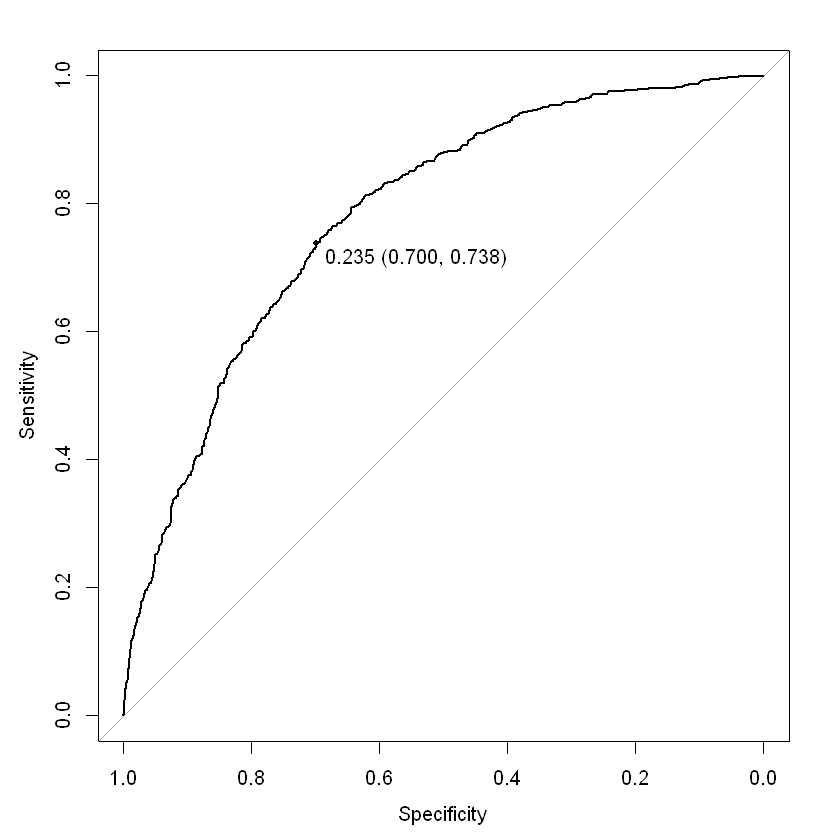

In [466]:
#Lets' look at the AUC for our first Logistic Regression model
result.roc_glm1 <- roc(test_set$churn_v2, predictions_glm_1$Churn) # Draw ROC curve.
 plot(result.roc_glm1, print.thres="best", print.thres.best.method="closest.topleft")
print(paste("The area under the curve for Glm 1 is",result.roc_glm1$auc))

[1] "The area under the curve for Glm 2 is 0.760434282071962"


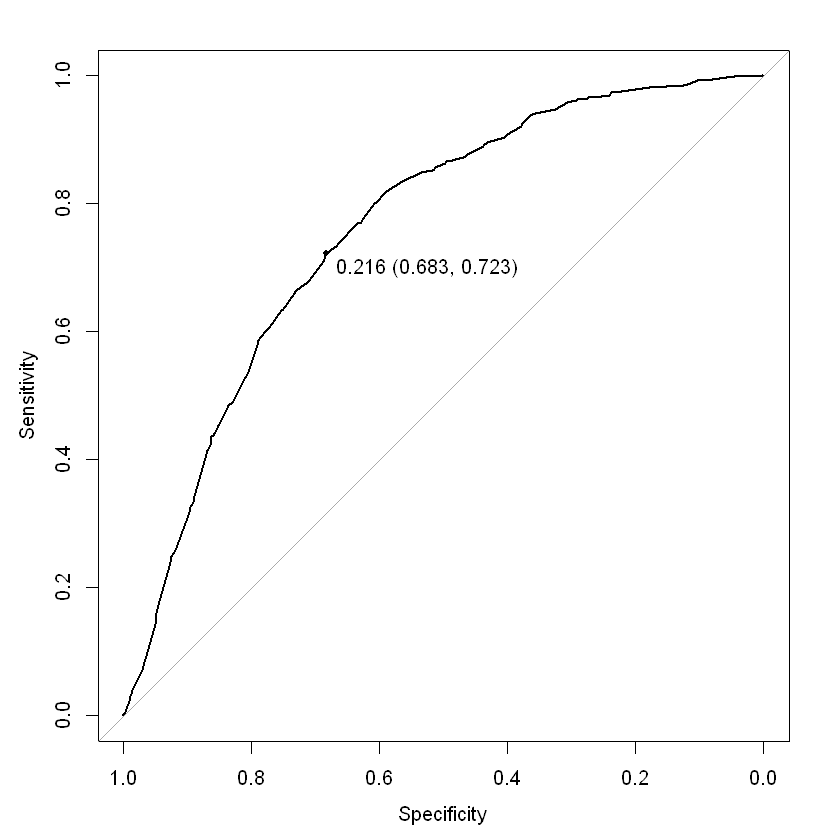

In [355]:
#Lets' look at the AUC for our Logistic Regression model version 2 (just has 2 predictors: average weight change and average visits)
# The 0.22 is the cutoff since that is the rate in the population of churn. We can adjust this level but will leave alone for this
#exercise. 
result.roc <- roc(test_set$churn_v2, predictions_glm_2$Churn) # Draw ROC curve.
 plot(result.roc, print.thres="best", print.thres.best.method="closest.topleft")
print(paste("The area under the curve for Glm 2 is",result.roc$auc))

[1] "The area under the curve for Glm 4 is 0.765234994926763"


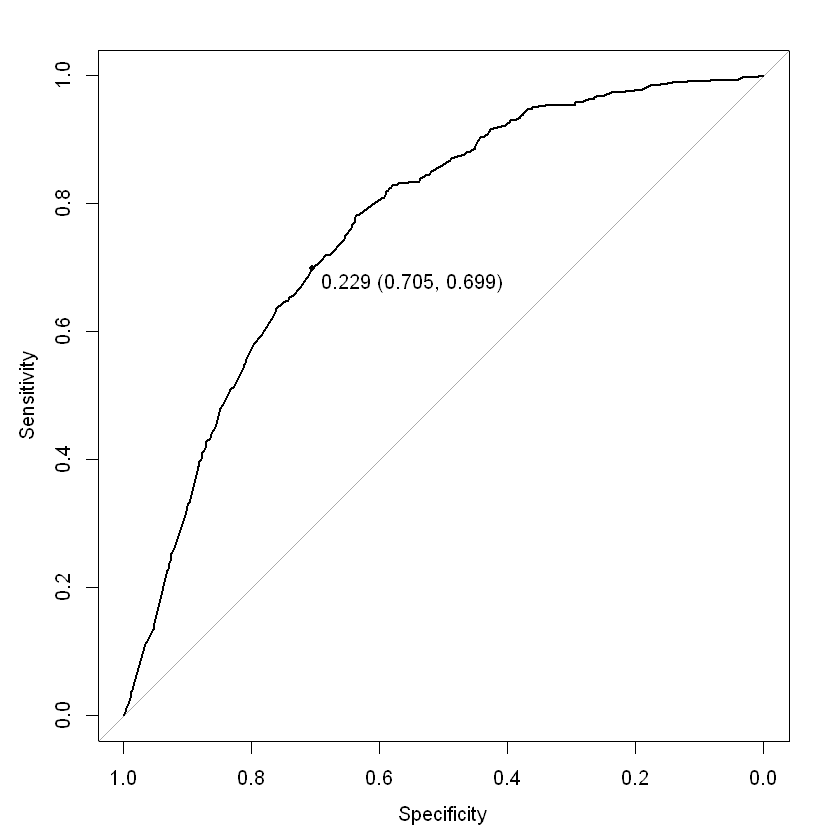

In [286]:
#Running another logistic regression model but we are adding another variable 'first month weight gain binned' 
model_glm_4 <- caret::train(churn_v2 ~ `avg_weight_change binned`+ `avg_visits binned` +  `first_month_weightgain binned`+ generation
                             , data = train_set, method = "glm", family = "binomial")
 predictions_glm_4 <- predict(model_glm_4,test_set, type = "prob")

colnames(predictions_glm_4) <- c('NoChurn','Churn')
result.roc_glm4 <- roc(test_set$churn_v2, predictions_glm_4$Churn) # Draw ROC curve.
 plot(result.roc_glm4, print.thres="best", print.thres.best.method="closest.topleft")
print(paste("The area under the curve for Glm 4 is",result.roc_glm4$auc))

In [361]:
model_knn <- train(churn_v2 ~ `avg_weight_change binned`+ `avg_visits binned` +
                              `first_month_weightgain binned` + membership + `total.spend binned` + generation
                   , data = train_set, method = "knn",
                   preProc = c("center","scale"),
                   tuneGrid = data.frame(.k = 1:20),
                   trControl = trainControl(method = "cv"))
predictions_knn <- predict(model_knn,test_set, type = "prob")

[1] "The area under the curve for KNN is 0.761713323100138"


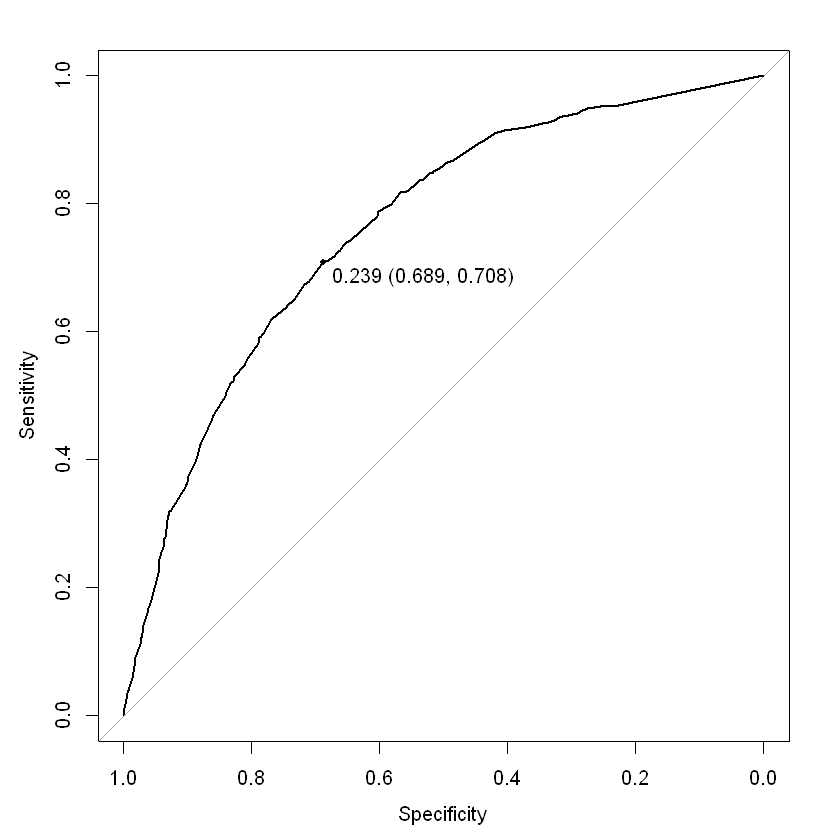

In [362]:
#
result.roc.knn <- roc(test_set$churn_v2, predictions_knn$Churn) # Draw ROC curve.
plot(result.roc.knn, print.thres="best", print.thres.best.method="closest.topleft")
print(paste("The area under the curve for KNN is",result.roc.knn$auc))

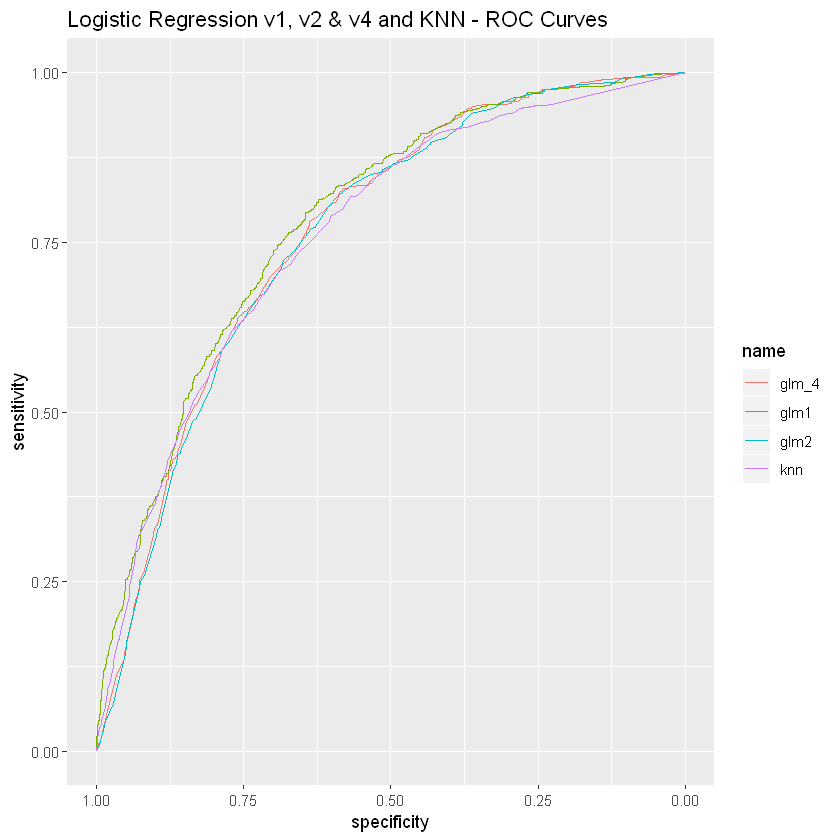

In [467]:
#Lets take a look at all three models together

gg_first_3_mods_ROC <- ggroc(list(glm1 = result.roc_glm1, glm2 = result.roc,glm_4 = result.roc_glm4, knn = result.roc.knn))
gg_first_3_mods_ROC + ggtitle('Logistic Regression v1, v2 & v4 and KNN - ROC Curves')

In [364]:
predictions_glm_all_data <- predict(model_glm, model_data_discrete, type = "prob")

In [371]:
dim(predictions_glm_all_data)

[1] 9562    2

In [365]:
head(predictions_glm_all_data)


No Churn,Churn
0.8714453,0.1285547
0.6850191,0.3149809
0.4819380,0.5180620
0.8131323,0.1868677
0.5239666,0.4760334
0.6191835,0.3808165


In [366]:
colnames(predictions_glm_all_data) <- c("GlmPredictedNoChurn","GlmPredictedChurn")


In [367]:
model_data_discrete$predicted_glm_NoChurn <- predictions_glm_all_data$GlmPredictedNoChurn
model_data_discrete$predicted_glm_Churn <- predictions_glm_all_data$GlmPredictedChurn

In [374]:
write.csv(model_data_discrete, 'model_data_01_30.csv')